# Wind Speed Analysis at Dublin Airport: insights and trends
***


![redanemometer](redanemometer.jpg)

## Context and Purpose
***

- Long-Term Wind Speed Trends at Dublin Airport
- timeframes (2000-2025)

## Getting ready
***

### Importing Libraries


In [2]:
# Data frames
import pandas as pd


# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Importing colormap module in Matplotlib
import matplotlib.cm as cm

# Importing scikit-learn (sklearn) for machine learning tasks
import sklearn 

# Importing specific functions from scikit-learn (sklearn)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



### Set up and installing

Ensure all the necessary tools are installed in Python environment:

1. Run in the terminal the following commands to install Jupyter notebook and pandas:


`pip install notebook`

`pip install pandas`

`pip install scikit-learn`

2. Check Jupyter extension is installed

3. Start the Kernel if It is not running to make sure the execution of all cells and output results.

### Loading data

In [3]:
# Loading data into notebook from csv file
data = pd.read_csv("clean_data_DublinAirport_weather.csv")

C:\Users\noemi\AppData\Local\Temp\ipykernel_17048\2029276336.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("clean_data_DublinAirport_weather.csv")


### Examine dataset

Once the data frame is uploaded, the analysis can proceed.The dataset used from Met Eireann at Dublin Airport has been cleaned and organized focus on four variables between the years 2000 and 2025:

- date: date
- airtemp: air tempeture in °C
- wdsp: Wind speed
- wddir: Wind direction

In [4]:
# Information about columns names and data types of variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218424 entries, 0 to 218423
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     218424 non-null  object 
 1   airtemp  218424 non-null  float64
 2   wdsp     218424 non-null  int64  
 3   wddir    218424 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.7+ MB


In [5]:
# Check for missing values
data.isnull().sum()


date       0
airtemp    0
wdsp       0
wddir      0
dtype: int64

In [6]:
# show the data
data.head()

,date,airtemp,wdsp,wddir
0,01/01/2000 01:00,3.3,7,250
1,01/01/2000 02:00,3.4,8,250
2,01/01/2000 03:00,2.2,6,240
3,01/01/2000 04:00,2.2,6,230
4,01/01/2000 05:00,1.9,7,250


In [7]:
# Statistics summary of numerical variables
data.describe()


,airtemp,wdsp
count,218424.000000,218424.000000
mean,9.857803,10.303927
std,5.025941,5.295946
min,-11.500000,0.000000
25%,6.300000,6.000000
50%,10.000000,10.000000
75%,13.500000,13.000000
max,29.100000,45.000000


## Data visualization

notes
- How much wind power in a day /year /month ?
- wind direction

#### Wind direction frequency

The following pie chart highlights the wind direction based on the cardinal points. The wind predominantly blows towards the West and South West with a slightly less frequency towards the East and North.

The wind direction data (in degrees) is usually given in terms of cardinal directions (e.g., North = 0 or 360 degrees, East = 90 degrees, South = 180 degrees, West = 270 degrees)

Also, experts in metheorology create groups or ranges for each cardinal and intercardinal direction to be more precie. Here is the range:

North (N): 337.5° to 22.5°
North-East (NE): 22.5° to 67.5°
East (E): 67.5° to 112.5°
South-East (SE): 112.5° to 157.5°
South (S): 157.5° to 202.5°
South-West (SW): 202.5° to 247.5°
West (W): 247.5° to 292.5°
North-West (NW): 292.5° to 337.5°

Below , It is possible to observe two pie charts with those two classification of data.

In [8]:
# Frequency. how often values appears in wddir column.
data['wddir'].value_counts()

wddir
240    9348
260    9272
250    8804
270    8169
230    7889
       ... 
10      764
360     726
0       143
0         8
          1
Name: count, Length: 75, dtype: int64

In [9]:
# Convert to numeric, convert invalid entries to NaN
data['wddir'] = pd.to_numeric(data['wddir'], errors='coerce')


In [10]:
# Check for NaN values
print(data['wddir'].isna().sum())  # Check for NaN values


1


In [11]:
# Define the cardinal directions based on degrees
def get_cardinal_direction(degrees):
    if degrees == 0 or degrees == 360:
        return 'North'
    elif degrees == 90:
        return 'East'
    elif degrees == 180:
        return 'South'
    elif degrees == 270:
        return 'West'
    else:
        return 'Other'

# Apply the function to the 'wddir' column
data['wddir_cardinal'] = data['wddir'].apply(get_cardinal_direction)

# Show the counts of cardinal directions
print(data['wddir_cardinal'].value_counts())


wddir_cardinal
Other    195769
West      14070
East       4210
South      2263
North      2112
Name: count, dtype: int64


In [12]:
# Identify and check data values from'other'row 
other_rows = data[data['wddir_cardinal'] == 'Other']
# Check the wind distribution for all those values
print(other_rows['wddir'].value_counts())


wddir
240.0    15266
250.0    14910
260.0    14530
230.0    13373
220.0    10825
280.0    10385
140.0     9578
210.0     8027
290.0     7651
150.0     7050
130.0     6966
200.0     6821
300.0     5935
120.0     5016
310.0     4941
80.0      4612
110.0     4475
160.0     4259
100.0     4162
190.0     3934
320.0     3784
70.0      3228
330.0     3127
60.0      2893
50.0      2869
40.0      2849
340.0     2837
170.0     2755
20.0      2268
30.0      2174
350.0     2161
10.0      2107
Name: count, dtype: int64


C:\Users\noemi\AppData\Local\Temp\ipykernel_17048\1514315048.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')
C:\Users\noemi\AppData\Local\Temp\ipykernel_17048\1514315048.py:15: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "_". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)


<function matplotlib.pyplot.show(close=None, block=None)>

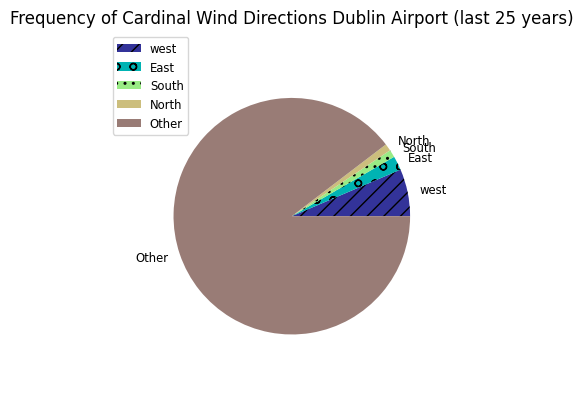

In [13]:
# Plotting a pie chart about the frequency of cardinal wind directions
# Data for pie chart
labels = 'west', 'East', 'South', 'North', 'Other'
sizes = [14070, 4210, 2263, 2112, 195769]

# Generate Colors from colormap module from matplotlib
cmap = cm.get_cmap('terrain')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

# Optional hatch patterns
hatch_patterns= ['//', 'o','..','_','']

# Create plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)
plt.title('Frequency of Cardinal Wind Directions Dublin Airport (last 25 years)')
plt.legend(labels, loc="best", fontsize="small")
plt.show

In [14]:
# Function to map degrees to cardinal or intercardinal directions
def get_cardinal_direction(degrees):
    if 337.5 <= degrees < 360 or 0 <= degrees < 22.5:
        return 'North (N)'
    elif 22.5 <= degrees < 67.5:
        return 'North-East (NE)'
    elif 67.5 <= degrees < 112.5:
        return 'East (E)'
    elif 112.5 <= degrees < 157.5:
        return 'South-East (SE)'
    elif 157.5 <= degrees < 202.5:
        return 'South (S)'
    elif 202.5 <= degrees < 247.5:
        return 'South-West (SW)'
    elif 247.5 <= degrees < 292.5:
        return 'West (W)'
    elif 292.5 <= degrees < 337.5:
        return 'North-West (NW)'
    else:
        return 'Invalid'

# Apply the function to the 'wddir' column in the  dataset to convert numerica values into corresponding cateogries.
data['wddir_cardinal'] = data['wddir'].apply(get_cardinal_direction)

# Display the updated dataframe with cardinal directions
print(data[['wddir', 'wddir_cardinal']].head())


   wddir   wddir_cardinal
0  250.0         West (W)
1  250.0         West (W)
2  240.0  South-West (SW)
3  230.0  South-West (SW)
4  250.0         West (W)


C:\Users\noemi\AppData\Local\Temp\ipykernel_17048\3703485600.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')
C:\Users\noemi\AppData\Local\Temp\ipykernel_17048\3703485600.py:16: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "_". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)


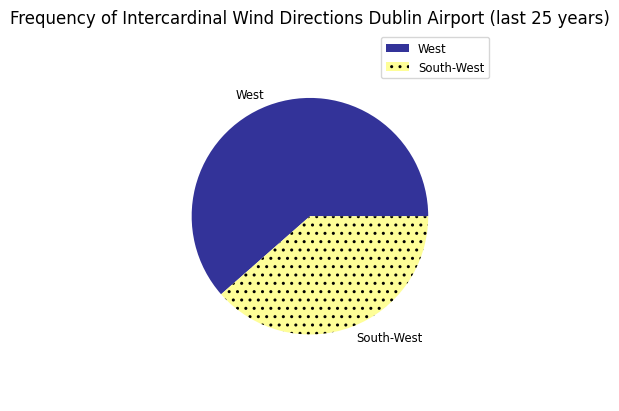

In [15]:
# Plot pie chart of Cardinal and intercardinal wind directions

# Data for the pie chart
labels = ['West', 'South-West']
sizes = [750, 470]

# Generate colors from the 'terrain' colormap
cmap = cm.get_cmap('terrain')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

# Optional hatch patterns
hatch_patterns = ['_', '..']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)

# Add title and legend
plt.title('Frequency of Intercardinal Wind Directions Dublin Airport (last 25 years)')
plt.legend(labels, loc="best", fontsize="small")

# Show the plot
plt.show()


## References

- Jupyter notebook format: 

https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

- Jupyter notebook text formatting: 

https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-text-files/format-text-with-markdown-jupyter-notebook/

- Free images:
https://pixabay.com/

- Classify the wind direction:
https://stackoverflow.com/questions/35864909/classify-the-wind-direction-in-several-classes

***
### End